<Body>   
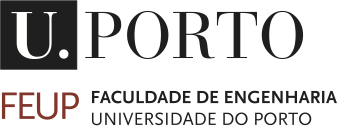   
<h1> <b>Control and Optimization 2023/2024 (2<sup>nd</sup> semester) </b> </h1>
<p>Master in Electrical and Computer Engineering </p>
<p>Department of Electrical and Computer Engineering</p>
</Body>  

**Professors:**

**A. Pedro Aguiar** (pedro.aguiar@fe.up.pt),
**M. Rosário Pinho** (mrpinho@fe.up.pt)

FEUP, Feb. 2024

---


# **Notebook #09: Optimization-based Control:**  
*Optimal Control Problems (OCP), Linear Quadratic Regulator (LQR) and Model Predictive Control (MPC)*



## **Introduction**

In this Notebook we  work with  optimal control for an example of a vehicle steering system. We use different methods of setting up optimal control problems and solving them using python-control systems library, in particular we use its OPTIMAL module for optimal control.

We will work out

1. LQR (Linear Quadratic Regulator)
2. Nonlinear OCP (Optimal Control Problem)
3. MPC (Model Predictive Control)

In [1]:
!pip install control

In [2]:
import numpy as np
import scipy as sp
import math
import control as ct
import control.optimal as opt
import matplotlib.pyplot as plt
import logging
import time
import os

### Vehicle steering dynamics

We start by defining the vehicle dynamics and also define a  plot utility function.




<table>
<tr>
    <td width="50%"><img src="https://fbswiki.org/wiki/images/5/52/Kincar.png" width=480></td>
    <td width="50%">

\begin{aligned}
  \dot x &= \cos\theta\, v \\
  \dot y &= \sin\theta\, v \\
  \dot\theta &= \frac{v}{l} \tan \delta, \qquad |\delta| \leq \delta_\text{max}
\end{aligned}

    </td>
</tr>
</table>

The vehicle dynamics are given by a simple bicycle model.  We take the state of the system as $(x, y, \theta)$ where $(x, y)$ is the position of the vehicle in the plane and $\theta$ is the angle of the vehicle with respect to horizontal.  The vehicle input is given by $(v, \delta)$ where $v$ is the forward velocity of the vehicle and $\delta$ is the angle of the steering wheel.  The model includes saturation of the vehicle steering angle.




In [3]:

 # System state: x, y, theta
 # System input: v, phi
 # System output: x, y
 # System parameters: wheelbase, maxsteer

 def vehicle_update(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    # Saturate the steering input
    phi = np.clip(u[1], -phimax, phimax)

    # Return the derivative of the state
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi)        # thdot = v/l tan(phi)
    ])

def vehicle_update_noised(t, x, u, params):
    # Get the parameters for the model
    l = params.get('wheelbase', 3.)         # vehicle wheelbase
    phimax = params.get('maxsteer', 0.5)    # max steering angle (rad)
    # Saturate the steering input
    phi = np.clip(u[1], -phimax, phimax)
    # Return the derivative of the state
    mu = 0.05
    sigma =0.01
    return np.array([
        np.cos(x[2]) * u[0],            # xdot = cos(theta) v
        np.sin(x[2]) * u[0],            # ydot = sin(theta) v
        (u[0] / l) * np.tan(phi) + np.random.normal(mu, sigma)       # thdot = v/l tan(phi)
    ])

def vehicle_output(t, x, u, params):
    return x                            # return x, y, theta (full state)

# Define the vehicle steering dynamics as an input/output system
vehicle = ct.NonlinearIOSystem(
    vehicle_update, vehicle_output, states=3, name='vehicle',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))

# Define the "real" vehicle steering dynamics with noise perturbation
vehicle_perturbed = ct.NonlinearIOSystem(
    vehicle_update_noised, vehicle_output, states=3, name='vehicle_perturbed',
    inputs=('v', 'phi'), outputs=('x', 'y', 'theta'))


 # Utility function to plot the results

 def plot_lanechange(t, y, u, yf=None, figure=None):
     plt.figure(figure)

     # Plot the xy trajectory
     plt.subplot(3, 1, 1)
     plt.plot(y[0], y[1])
     plt.xlabel("x [m]")
     plt.ylabel("y [m]")
     if yf is not None:
         plt.plot(yf[0], yf[1], 'ro')

     # Plot the inputs as a function of time
     plt.subplot(3, 1, 2)
     plt.plot(t, u[0])
     plt.xlabel("t [sec]")
     plt.ylabel("velocity [m/s]")

     plt.subplot(3, 1, 3)
     plt.plot(t, u[1])
     plt.xlabel("t [sec]")
     plt.ylabel("steering [rad/s]")

     plt.suptitle("Lane change manuever")
     plt.tight_layout()
     plt.show(block=False)

## **Activity 1 - LQR**

We consider an optimal control problem that consists of “changing lanes” by moving from the point $x = -100$ m, $y = -4$ m, $\theta = 0$ to the point $x = 0$ m, $y = 0$ m, $\theta = 0$ over a period of 10 seconds  starting with a velocity of 10 m/s:

**1.1** Obtain a linearized model of the system around the point $x*=(-50,-2,0)$, $*u=(10,0)$.

**1.2.** Now, having a linear system of the form
$$
\dot x = A x + Bu
$$
obtain the linear feedback function
$$
 u = - K x
$$
 that  minimizes the quadratic cost function
$$
J=\int_0^\infty (x^T Q x + u^T R u) dt.
$$


**1.3.** Try different values for matrices Q, and R  with the aim to obtain a fast lane changing manouver while not exceeding a maximum steering angle of 0.5 rad (aprox. 28 degrees).

**1.4** What is total cost $J$ of the solution. Which are the eigenvalues of the resulting closed-loop system.


<LinearIOSystem>: sys[4]
Inputs (2): ['u[0]', 'u[1]']
Outputs (3): ['y[0]', 'y[1]', 'y[2]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[ 0.0000000e+00  0.0000000e+00 -5.0004445e-06]
     [ 0.0000000e+00  0.0000000e+00  1.0000000e+01]
     [ 0.0000000e+00  0.0000000e+00  0.0000000e+00]]

B = [[1.         0.        ]
     [0.         0.        ]
     [0.         3.33333333]]

C = [[1. 0. 0.]
     [0. 1. 0.]
     [0. 0. 1.]]

D = [[0. 0.]
     [0. 0.]
     [0. 0.]]

K, P, E [[ 4.47213595e+00  1.22972534e-06 -3.68917602e-07]
 [-1.22972534e-06  4.47213595e+00  6.84345057e+00]] [[ 4.47213596e+00  1.22972534e-06 -3.68917602e-07]
 [ 1.22972534e-06  3.06048414e+00  1.34164079e+00]
 [-3.68917602e-07  1.34164079e+00  2.05303517e+00]] [ -4.47213595+0.j        -11.40575095+4.3566092j -11.40575095-4.3566092j]


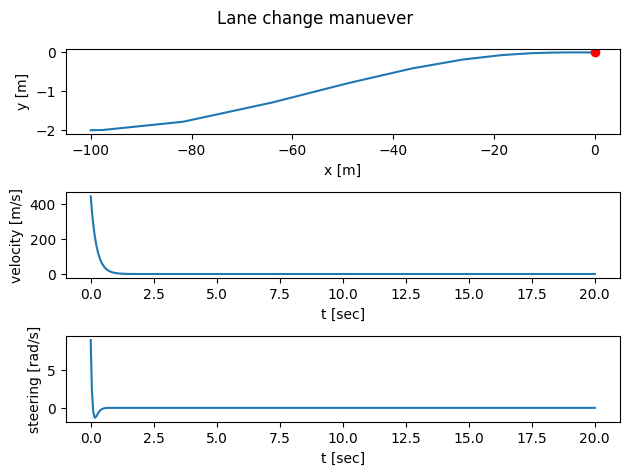

In [9]:
# To complete. Check control.lqr function

# Linearization Point
x_star = np.array([-50, -2., 0.])
u_star = np.array([10, 0])               # only used for linearization

# Linearized dynamics
sys = vehicle.linearize(x_star, u_star)
print(sys)


# Initial conditions for the linear system
x0 = np.array([-50., -2., 0.])
x0 = np.array([-100, -2., 0.])
u0 = np.array([1., 0.])

xf = np.array([0., 0., 0.]) # target

# Define the cost function and the terminal cost
# (try changing these later to see what happens)
Q = np.diag([20, 20, 20])       # state costs
R = np.diag([1, 1])          # input costs
#R = np.diag([0.1, 0.1])          # input costs
#F = np.diag([1, 1, 1])       # terminal costs

# Solve LQR
K, P, E = ct.lqr(sys.A, sys.B, Q, R)
print("K, P, E", K, P, E)

# Dynamics of the CL system
def sys_cl_update(t, x):
    u = -K @ x
    return sys.A @ x + sys.B @ u

# Now simulate from a shifted initial condition
Tf = 20
xsol = sp.integrate.solve_ivp(sys_cl_update, (0, Tf), x0)
t1 = xsol.t
y1 = xsol.y
u1= -K @ y1
# Plot
plot_lanechange(t1, y1, u1, yf=xf[0:2])

## **Activity 2 - Nonlinear OCP**

Consider now  optimal control problem that consists of “changing lanes” by moving from the point x = 0 m, y = -2 m, \theta = 0 to the point x = 100 m, y = 2 m, \theta = 0) over a period of 10 seconds and with a with a starting and ending velocity of 10 m/s, where we  explicitly constrain the maximum turning rate to 0.5 radians (about 28 degrees) and constrain the velocity to be in the range of 8 m/s to 12 m/s.
Consider a quadratic cost
$$
\int_0^T (x^T Q x + u^T R u) dt + x(T)^T F x(T).
$$
Consider Q and R as in the previous activity. Consider F=P where P solves the algebraic Riccatti equation of the linearized infinite-horizon problem of the previous activity.


Plot the solution given by the optimizer as well as the solution obtained by simulation with the optimal input and the perturbed dynamics "vehicle_perturbed".

Summary statistics:
* Cost function calls: 2646
* Cost function process time: 0.59375
* Constraint calls: 2774
* Constraint process time: 0.453125
* System simulations: 0
* Final cost: 29415.059342165983
* Total time = 6.82812 seconds



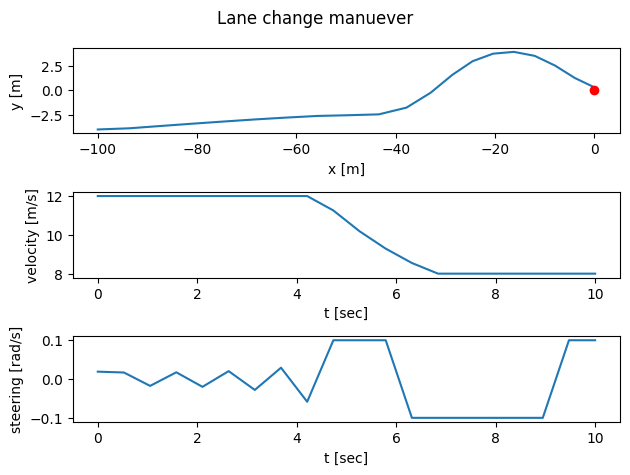

Final computed state:  [ 0.18605253  0.27918423 -0.16764117]


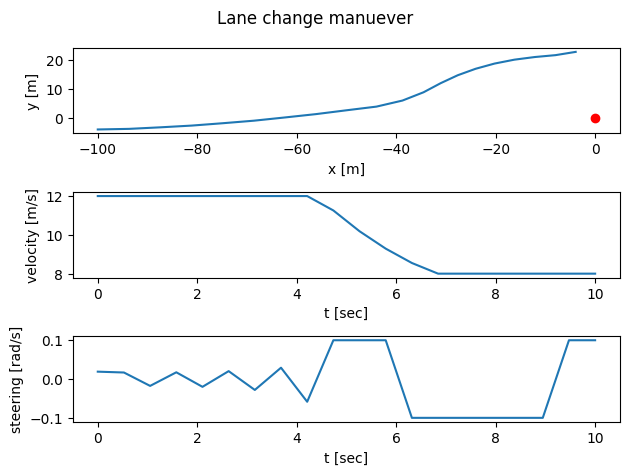

Final simulated state: [-3.91317715 22.8800885   0.35230862]


In [6]:
# To complete. Check solve_ocp function

# Optimal control problem
#
# Perform a "lane change" manuever over the course of 10 seconds.
#

# Initial and final conditions
x0 = np.array([-100., -4., 0.]); u0 = np.array([10., 0.])
xf = np.array([0., 0., 0.]); uf = np.array([10., 0.])
Tf = 10
N = 20 # number of time discretization points


#
# Set up the cost functions
Q = np.diag([1, 1, 1])       # keep lateral error low
R = np.diag([20, 20])            # minimize applied inputs
K, P, E = ct.lqr(sys.A, sys.B, Q, R)
F = 100*P                  # where P Solves the ARE from LQR
#quad_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
constraints = [ opt.input_range_constraint(vehicle, [8, -0.1], [12, 0.1]) ]
traj_cost = opt.quadratic_cost(vehicle, Q, R, u0=uf)
term_cost = opt.quadratic_cost(vehicle, F, None, x0=xf)

# Define the time horizon (and spacing) for the optimization
timepts = np.linspace(0, Tf, N, endpoint=True)

# Provide an initial guess
straight_line = (
    np.array([x0 + (xf - x0) * time/Tf for time in timepts]).transpose(),
    np.outer(u0, np.ones_like(timepts))
)

# Turn on debug level logging so that we can see what the optimizer is doing
#logging.basicConfig(
#    level=logging.DEBUG, filename="steering-integral_cost.log",
#    filemode='w', force=True)

# Compute the optimal control, setting step size for gradient calculation (eps)
start_time = time.process_time()
"""
def solve_ocp(sys, timepts, X0, cost, trajectory_constraints=None, terminal_cost=None, terminal_constraints=None, initial_guess=None, basis=None, squeeze=None, transpose=None, return_states=True, print_summary=True, log=False, **kwargs)
Compute the solution to an optimal control problem.

The optimal trajectory (states and inputs) is computed so as to approximately mimimize a cost function of the following form (for continuous time systems):

  J(x(.), u(.)) = \int_0^T L(x(t), u(t)) dt + V(x(T)),

where T is the time horizon.
"""
result1 = opt.solve_ocp( vehicle, timepts, x0, traj_cost, constraints, terminal_cost=term_cost,
    initial_guess=straight_line, log=True,
    # minimize_method='trust-constr',
    # minimize_options={'finite_diff_rel_step': 0.01},
)
print("* Total time = %5g seconds\n" % (time.process_time() - start_time))

# If we are running CI tests, make sure we succeeded
#if 'PYCONTROL_TEST_EXAMPLES' in os.environ:
#    assert result1.success

# Plot the results from the optimization
plot_lanechange(timepts, result1.states, result1.inputs, xf, figure=1)
print("Final computed state: ", result1.states[:,-1])

# Simulate the system and see what happens
t1, u1 = result1.time, result1.inputs
#t1, y1 = ct.input_output_response(vehicle, timepts, u1, x0)
t1, y1 = ct.input_output_response(vehicle_perturbed, timepts, u1, x0)
plot_lanechange(t1, y1, u1, yf=xf[0:2], figure=1)
print("Final simulated state:", y1[:,-1])

## **Activity 3 - MPC**

To have some robustness, we should include feedback, which can be done by solving the optimal control problems repeadily, using as initial state the current measured state, in a receding horizon strategy.

Implement a MPC algorithm for this problem. In each MPC step  use as initial guess the solution from the previous OCP.

You can reduce the time horizon (and the discretization points) in each OCP to speed up solution.




Summary statistics:
* Cost function calls: 4473
* Cost function process time: 0.921875
* Constraint calls: 4619
* Constraint process time: 0.890625
* System simulations: 0
* Final cost: 28057.749144806556
MPC iteration  0
Summary statistics:
* Cost function calls: 104
* Constraint calls: 207
* System simulations: 0
* Final cost: 28057.749144777637
[12.          0.06511375]
MPC iteration  1
Summary statistics:
* Cost function calls: 105
* Constraint calls: 208
* System simulations: 0
* Final cost: 28057.749144742473
[12.          0.06511691]
MPC iteration  2
Summary statistics:
* Cost function calls: 105
* Constraint calls: 208
* System simulations: 0
* Final cost: 28057.749144721663
[12.          0.06511425]
MPC iteration  3
Summary statistics:
* Cost function calls: 104
* Constraint calls: 207
* System simulations: 0
* Final cost: 28057.749144691188
[12.          0.06511814]
MPC iteration  4
Summary statistics:
* Cost function calls: 105
* Constraint calls: 208
* System simulations: 0

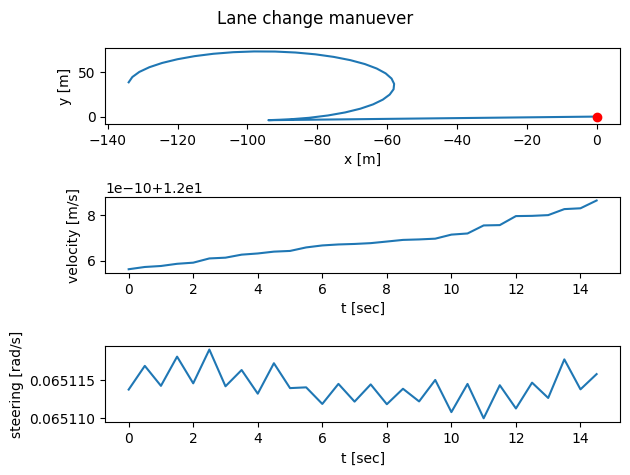

Final computed state:  [-133.99874075   38.1995931     4.68410302]


In [8]:
# To complete. MPC

# Set the OCP
#  Solve first OCP
# Initiate the MPC loop.
#  1. Measure current state
#  2. Solve OCP for current state
#  3. Apply control to the plant and get next state
#  4. Store solution and repeat

# Initial and final conditions
x0 = np.array([-100., -4., 0.]); u0 = np.array([10., 0.])
xf = np.array([0., 0, 0.]); uf = np.array([10., 0.])
T = 10  # optimization horizon
N = 20 # number of time discretization points in the optimization
#Tf = 20 # Final simulation time
dt= T/N

#
# Set up the cost functions
Q = np.diag([1, 1, 1])       # keep lateral error low
R = np.diag([1, 1])            # minimize applied inputs
F = 100*P                  # where P Solves the ARE from LQR
#quad_cost = opt.quadratic_cost(vehicle, Q, R, x0=xf, u0=uf)
constraints = [ opt.input_range_constraint(vehicle, [0, -0.1], [12, 0.1]) ]
traj_cost = opt.quadratic_cost(vehicle, Q, R, u0=uf)
term_cost = opt.quadratic_cost(vehicle, F, None, x0=xf)

# Define the time horizon (and spacing) for the optimization
timepts = np.linspace(0, T, N, endpoint=True)

# Provide an initial guess
straight_line = (
    np.array([x0 + (xf - x0) * time/T for time in timepts]).transpose(),
    np.outer(u0, np.ones_like(timepts))
)

# Turn on debug level logging so that we can see what the optimizer is doing
#logging.basicConfig(
#    level=logging.DEBUG, filename="steering-integral_cost.log",
#    filemode='w', force=True)

# Compute the optimal control, setting step size for gradient calculation (eps)
# start_time = time.process_time()
result1 = opt.solve_ocp( vehicle,
	timepts, x0, traj_cost, constraints, terminal_cost=term_cost,
    initial_guess=straight_line, log=True,
    # minimize_method='trust-constr',
    # minimize_options={'finite_diff_rel_step': 0.01},
)
#print("* Total time = %5g seconds\n" % (time.process_time() - start_time))

# If we are running CI tests, make sure we succeeded
#if 'PYCONTROL_TEST_EXAMPLES' in os.environ:
#    assert result1.success

initial_guess1=result1.states, result1.inputs

def NextState(xi,ui):
  xi1 = xi + dt*vehicle_update_noised(0, xi, ui, {})
  return xi1

# Initiate the MPC loop.
MaxMPCiters=30
Tf=MaxMPCiters*dt
t_signal = np.arange(0,Tf,dt)
u_signal = np.zeros((2,len(t_signal)))
x_signal = np.zeros((3,len(t_signal)+1))
xi=x0.copy()
for i in range(0,MaxMPCiters):
  print("MPC iteration ",i)
  #  1. Measure current state xi
  #  2. Solve OCP for current state
  result1 = opt.solve_ocp( vehicle,
	  timepts, x0, traj_cost, constraints, terminal_cost=term_cost,
      initial_guess=initial_guess1, log=False)
  initial_guess1= result1.states, result1.inputs
  #  3. Apply control to the plant and get next state
  ui=result1.inputs[:,0]
  print(ui)
  x_next=NextState(xi,ui)
  #  4. Store solution and repeat
  u_signal[:,i]=ui
  x_signal[:,i+1]=x_next
  xi=x_next.copy()

print("u1", u_signal[0])
print("x1",x_signal[0])

# Plot the results from the optimization
plot_lanechange(t_signal, x_signal, u_signal, xf, figure=1)
print("Final computed state: ", x_signal[:,-1])

## Simulate the system and see what happens
#t1, u1 = result1.time, result1.inputs
#t1, y1 = ct.input_output_response(vehicle_perturbed, timepts, u1, x0)
#plot_lanechange(t1, y1, u1, yf=xf[0:2], figure=1)
#print("Final simulated state:", y1[:,-1])